*By: B830459\
Date: 20/1/2023*

## Program Explanation: 

The program is split into two outputs under two functions.

The first one - **bad_attendance ( )**, returns a dataframe, which is enclusive of all the students with poor attendance and their weekly average and overall average attendace. Poor attendance has been has been determined using ***two characteristics***: 
- the overall average attendance of the student must below the average attendace for all the modules encompassing the department
- the student has 2 or more consecutive weeks of not attending a single lecture. 

The second - **graphing ( )**, returns a scatter plot for individual attendance during all the teaching weeks for all students with poor attendance, who have attended at least a single lecture across the modules timespan. Students that have not attended any lectures are **not included** into the graph, as they would be only clustering the bottom of the x - axis. Further the scatter point, have substantial amount of horizontal and vertical jitter, in order for the user to be able to distinguish amongst overlapping points. The boundaries between each week have been lightly shaded in grey, so that the user can identify easily which points refer for which week.\
Further on the plot, line graphs will be representing the average weekly attendance across the modules within the department. 

In order for the first output to be executed the user, must specify the fucntion **bad_attendance ( )** paramter.\
This is a dictionary with all the modules names as keys and their formatted dataframe form from **neat_table( )** as values.\
If this function is used alongside the **higligther( )** function, all the students with poor attendance, that in a given week have an average attendance higher that the department one, will be highlighted in light green.


In order for the second output to be executed the user, must specify the fucntion **graphing ( )** paramters.\
Those are a dictionary with all the modules names as keys and their formatted dataframe form from **neat_table( )** as values. Alongside a dataframe with students that have poor attendance must be provided. In this case convinietly the function **bad_attendace( )** with its specified paramater will do the job. 

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import random
import sqlite3
from IPython.display import clear_output
from tkinter import *

## Database Imports

In [2]:
def import_from_db(df_name):
    """
    
    Imports SQL tables from CWDatabase.db
    in the form of pandas dataframe.
    
    The function requries to be provided with:
    df_name -> the SQL table name as a 
    string type
    
    """
    conn = sqlite3.connect("CWDatabase.db")
    
    table_to_get = "SELECT * FROM " + df_name
    import_sql = pd.read_sql(table_to_get, conn)
    
    conn.close()
    
    return import_sql

## Extracing information from imported database tables

In [3]:
def neat_table(df, timetable):
    """
    
    Creates a dataframe, provided:
    
    df -> the students attendance SQL 
    table name as a string type
    timetable -> the modules timetable SQL 
    table name as a string type
    
    The newly created dataframe, sets the 
    "Timetable" type table from the 
    database and its respective values as 
    index for the "Records" table.
    Each individual students attendance 
    is represented under a column, 
    matching the respective multi index 
    for the specific class/lecture.
    
    """
    # Modifying the student records table, so that it includes a session id KEY 
    indexed = import_from_db(df).set_index("student_id")
    records = indexed.T
    empty = []
    for i in records.index:
        get_after = "Session_ID:_"
        result = i.split(get_after, 1)
        empty.append(int(result[1]))
    
    records["sess_id"] = empty
    
    # Importing the timetable 
    schedule = import_from_db(timetable)
    
    # Merging the updated records DF with the timetable DF
    complete_module = pd.merge(schedule, records, on = "sess_id")
    
    # Indexes that have to be set of the concated DF
    index = ["sem", "week", "sess_id", "date", "time", "type", "room"]
    
    # Setting those indexes to work 
    complete_module.set_index(index, inplace = True)
    
    # Fillining all Nans to 0
    complete_module = complete_module.fillna(0)
    
    return complete_module

## Main

In [4]:
def weekly_attendance_per_module(func):
    """
    
    Provides a dataframe which includes the 
    weekly average attendances for each module. 
        
    The function requries to be provided with:
    func -> a dictionary containing as its values, 
    dataframes for the individual modules, being processed
    under the neat_table() function
    
    """
    weekly_module_attendance_dict = {}
    for i in func: 
        weekly_module_attendance = (func[i].groupby("week").sum().sum(1) /\
                                    func[i].groupby("week").count().sum(1) * 100)
        weekly_module_attendance_dict[i] = weekly_module_attendance.round(2)
    
    # Making the dictionary from above into a dataframe
    weekly_attendance_table = pd.DataFrame(weekly_module_attendance_dict)
    weekly_attendance_table = sort_weeks_in_df(weekly_attendance_table)
    
    return weekly_attendance_table

In [5]:
def bad_attendance(func):
    """
    
    Provides a dataframe containing the weekly attendance 
    and overall average attendance of only students 
    with considered "bad attendance" across all of 
    the modules present in the dictionary provided.
    The records are in descending order of overall 
    average attendance.
    
    The function requries to be provided with:
    func -> a dictionary containing as its values, 
    dataframes for the individual modules, being processed
    under the neat_table( ) function
    
    """
    
    # Merge horizontally all of the dataframes present in the inputted dictionary
    modules_data = list(func.values())
    global merged
    merged = pd.concat(modules_data)
    
    # Department avg attendance
    dept_avg_att = (merged.sum().sum() /\
                    merged.count().sum() * 100).round(1)
    
    # Student avg attendance
    student_avg_att = (merged.sum() /\
                       merged.count() * 100).round(1)

    # Table for working with for final answer 
    result = ((merged.groupby("week").sum() /\
               merged.groupby("week").count() * 100).round(1))  
    
    # Sort the weeks from the index in ascending order
    result = sort_weeks_in_df(result)

    # Making it more managable to work with 
    result = result.T

    # Calculaitons related to consecutive missed weeks 
    # extract attandance data in a list form for each individual student
    attendance_data_list = result.values == 0
    attendance_data_list = attendance_data_list.astype(int).tolist()
    
    # Generate a list containing the consecutive missed weeks per student
    consec = []
    for i in range(len(attendance_data_list)):
        list_to_examine = attendance_data_list[i]
        count = 0
        consecutive_counter = 0
        for i in range(len(list_to_examine)): 
            if (list_to_examine[i] == 0):
                count = 0
            else:
                count += 1
                consecutive_counter = max(consecutive_counter, count)

        consec.append(consecutive_counter)
        
    # Add the new columns generated above
    result["student_avg_att"] = student_avg_att
    result["dept_avg_att"] = dept_avg_att
    result["consecative_missed_weeks"] = consec
    
    
    # Filtering 
    bad_attendance_df = result[(result["student_avg_att"] < dept_avg_att) & 
                            (result["consecative_missed_weeks"] >= 2)]
    bad_attendance_df = bad_attendance_df.sort_values("student_avg_att", ascending = False)
    ans = bad_attendance_df.iloc[:, :-2]
    
    
    # Formatting end result
    ans = ans.rename_axis("Student ID", axis = 0)
    ans = ans.rename_axis(None, axis = 1)
    ans.sort_values(by = ["student_avg_att"], ascending = False, inplace = True)
    ans.rename(columns = {"student_avg_att": "Average Attendance %"}, inplace = True)
    
    return ans

The colours list has been generated by combining 2 colour pallets found online. In order to create distinguishable colours for the scatter points.
The colour pallets have been taken from:\
https://sashamaps.net/docs/resources/20-colors/ \
http://phrogz.net/tmp/24colors.html

In [6]:
def graphing(func, attendance_tables):
    """
    
    Graphes all of the students with poor attendance
    and having attended at least a single lecture
    on a scatterplot, whilist adding some jitter to all 
    of the points, in order to distinguish inbetween 
    overlapping points. 
    
    Further the function plots the average weekly 
    attendance for each module as a line graph.
    
    The function requries to be provided with:
    func -> a dictionary containing as its values, 
    dataframes for the individual modules, being processed
    under the neat_table( ) function
    attendance_tables -> a dataframe containing students 
    with poor attendance
    
    """
    # Formatting regarding the jitter of the scatter plot
    # Import of poor attendance DataFrame
    df = attendance_tables
    df = df[df["Average Attendance %"] != 0]
    students_scatter_points = df.iloc[:, :-1].T
    
    # Creating a DataFrame containing the values for the vertical jitter
    np.random.seed(124)
    y_jitter = students_scatter_points \
    + np.random.rand(* students_scatter_points.shape) * 0.8
    
    # Creating a DataFrame containing the values for the horizontal jitter 
    x_jitter = []
    width = 0.7
    for i in range(len(students_scatter_points.index)):
        np.random.seed(124)
        jitter_by = np.ones(students_scatter_points.shape[1]) * i \
        + (np.random.rand(students_scatter_points.shape[1]) * width-width / 2.)
        x_jitter.append(jitter_by)
        
        
    x_jitter = pd.DataFrame(x_jitter)
    x_jitter.columns = students_scatter_points.columns
    x_jitter.index = students_scatter_points.index
        
    
    # Importing the colours to be used in the graphing
    colours = ["#E6194B", "#3CB44B", "#FFE119", "#4363D8", 
               "#F58231", "#911EB4", "#E7E9B9", "#42D4F4", 
               "#FFFF00", "#8F2323", "#F032E6", "#FABED4", 
               "#469990", "#DCBEFF", "#9A6324", "#FFFAC8", 
               "#800000", "#AAFFC3", "#808000", "#FFD8B1", 
               "#000075", "#A9A9A9", "#FFFFFF", "#000000", 
               "#FF0000", "#FF7F00", "#DCB9ED", "#BFFF00",
               "#6AFF00", "#00EAFF", "#0095FF", "#0040FF", 
               "#FF00AA", "#AA00FF", "#EDB9B9", "#737373", 
               "#B9D7ED", "#8F6A23", "#4F8F23", "#23628F", 
               "#6B238F", "#000000", "#BFEF45", "#CCCCCC"]
    
    
    custom_cmap= matplotlib.colors.ListedColormap(colours)  
    
    # Plotting the scatter for students with poor attendance
    fig = plt.figure()
    cm_scatter = custom_cmap
    num_colours_scatter = len(students_scatter_points.columns) 
    ax = fig.add_subplot(111)
    ax.set_prop_cycle("color", 
                      [cm_scatter(1. * i / num_colours_scatter) 
                       for i in range(num_colours_scatter)])
    
    for i in range(len(students_scatter_points.columns)):
        ax.scatter(x_jitter.iloc[:, i], y_jitter.iloc[:, i], 
                   alpha = 0.55, s = 90, edgecolors = "black", 
                   label = students_scatter_points.columns[i])    
    
    # Plotting the line graph for module's weekly average attendance 
    cm_line = plt.get_cmap("Set1")
    num_colours_line = len(func)
    ax.set_prop_cycle("color", 
                      [cm_line(1. * i / num_colours_line) 
                       for i in range(num_colours_line)])
    
    for i in range(len(func)):
        ax.plot(weekly_attendance_per_module(func).iloc[:, i], 
                linestyle = "-", linewidth = 2.5,
                alpha = 0.65, label = list(func.keys())[i].upper())
    
    # Graph's global property settings
    ax.legend(loc = "center left", bbox_to_anchor = (1, 0.5))
 
    ax.set_ylim([-5, 108])
    ax.set_xlim([-0.5, len(students_scatter_points) - 0.5])

    ax.set_xlabel("Week No")
    ax.set_ylabel("Attendance %")
    ax.tick_params(axis = "x", which = "major", pad = 10)
    ax.set_yticks(np.arange(0, 110, 10))
    ax.set_xticks(range(len(x_jitter.index)))
    ax.set_xticklabels(x_jitter.index)
    
    ax.grid(axis = "y", color = "black", linestyle = "-", 
            linewidth = 0.5, alpha = 0.2)
    ax.grid(axis = "x", color = "black", linestyle = "-", 
            linewidth = 78, alpha = 0.035)
    
    fig.subplots_adjust(left= -0.4)
    fig.subplots_adjust(bottom = -0.1)
    
    
    plt.show()


## Styling of end output

In [7]:
def sort_weeks_in_df(df):
    """    
    
    Neats a provided dataframe, by sorting out 
    the week's indexes in a ascending order, 
    in the scenario that a week's 
    number includes 2 or more digits. 
    
    """ 
    ordered_weeks = []
    for i in df.index:
        ordered_weeks.append(int(i[1:]))
    
    df["week_number"] = ordered_weeks
    df = df.sort_values("week_number")
    df.drop("week_number", inplace = True, axis = 1)
    
    return df

In the function below the "Average Attendance %" column is forced to be 101.
The reasoning for this is so even if average attandance is 100%, the highlighter
function won't be able to highligh the any of the column values. 

In [8]:
def week_average(): 
    """
    
    Provided the "merged" dataframe from
    bad_attendance(), it calculates the average
    attendance for each week for all modules
    that have been imported into bad_attendance().
    
    """
    week_avg = (merged.groupby("week").sum().sum(1) /\
                merged.groupby("week").count().sum(1) * 100)\
                .round(2)
    week_avg = pd.DataFrame(week_avg)
    week_avg = sort_weeks_in_df(week_avg)
    week_avg = week_avg.T
    week_avg["Average Attendance %"] = 101

    return week_avg

In [9]:
def highlighter(df):
    """
    
    Provided the "week_average" function
    it higlights in green all of the values in 
    inputted dataframe, that exceed the values 
    of "week_average".
    
    The function requries to be provided with:
    df -> dataframe containing attendance information
    for each student across individual weeks
    
    """
    conds = [df > week_average().iloc[0]]
    labels = ["background-color:lightgreen"]
    
    return np.select(conds, labels, default = " ")

## Testing

In [10]:
def import_modules():
    """
    
    The function intiliazes all of the modules information 
    into "neat" dataframes, by making use of the 
    neat_table( ) function.
    
    The function is used predomentatly as a 
    dictionary to access multiple modules 
    attendances. 
    
    """
    
    coa111 = neat_table("dfcoa111", "sesscoa111")
    coa122 = neat_table("dfcoa122", "sesscoa122")
    
    return locals()

In [11]:
bad_attendance(import_modules())

,W1,W2,W3,W4,W5,W6,Average Attendance %
Student ID,,,,,,,
106,0.0,0.0,80.0,83.3,80.0,100.0,51.9
21,60.0,60.0,60.0,50.0,0.0,0.0,44.4
81,0.0,0.0,60.0,66.7,60.0,100.0,40.7
23,0.0,0.0,60.0,50.0,80.0,100.0,40.7
170,80.0,40.0,20.0,33.3,0.0,0.0,33.3
146,60.0,40.0,60.0,0.0,0.0,0.0,29.6
82,20.0,60.0,20.0,50.0,0.0,0.0,29.6
56,40.0,0.0,80.0,16.7,0.0,0.0,25.9
50,60.0,0.0,0.0,16.7,40.0,100.0,25.9


In [12]:
week_average()

week,W1,W2,W3,W4,W5,W6,Average Attendance %
0,58.59,58.19,55.68,56.2,53.07,76.38,101


In [13]:
bad_attendance(import_modules()).style.apply(highlighter, axis = 1).set_precision(2)

,W1,W2,W3,W4,W5,W6,Average Attendance %
Student ID,,,,,,,
106,0.00,0.00,80.00,83.30,80.00,100.00,51.90
21,60.00,60.00,60.00,50.00,0.00,0.00,44.40
81,0.00,0.00,60.00,66.70,60.00,100.00,40.70
23,0.00,0.00,60.00,50.00,80.00,100.00,40.70
170,80.00,40.00,20.00,33.30,0.00,0.00,33.30
146,60.00,40.00,60.00,0.00,0.00,0.00,29.60
82,20.00,60.00,20.00,50.00,0.00,0.00,29.60
56,40.00,0.00,80.00,16.70,0.00,0.00,25.90
50,60.00,0.00,0.00,16.70,40.00,100.00,25.90


In [14]:
weekly_attendance_per_module(import_modules())

,coa111,coa122
week,,
W1,67.59,52.60
W2,75.13,46.90
W3,69.35,46.57
W4,69.10,49.75
W5,69.35,42.21
W6,NaN,76.38


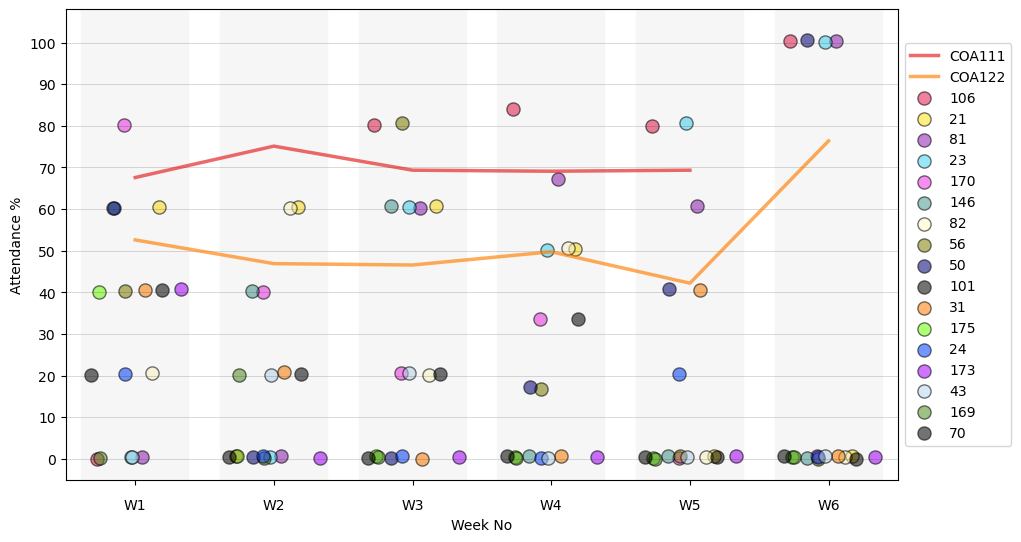

In [15]:
graphing(import_modules(), bad_attendance(import_modules()))